## 0. **필요 라이브러리 호출**

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm
import os
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter

---
---
---

## **1. 데이터 로드 및 전처리**

### **(1) 운영 체제에 따른 한글 폰트 경로 설정**

In [46]:
system = platform.system()

if system == 'Windows':
    font_name = 'Malgun Gothic'  # 윈도우 기본 고딕체, 가장 무난하고 부드러움

elif system == 'Darwin':  # macOS
    font_name = 'Apple SD Gothic Neo'  # Apple 기본 설치, 곡선이 더 부드러움

elif system == 'Linux':
    # 기본 설치 여부 불확실하므로 fallback 포함
    font_candidates = ['NanumGothic', 'UnDotum', 'DejaVu Sans', 'Liberation Sans']
    import matplotlib.font_manager as fm
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    font_name = next((f for f in font_candidates if f in available_fonts), 'sans-serif')
else:
    font_name = 'sans-serif'  # 최후 fallback

# matplotlib에 적용
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

In [114]:
region_name_map = {
    "서울": "seoul",
    "경기": "gyeonggi",
    "인천": "incheon",
    "충청": "chungcheong",
    "대전": "daejeon",
    "대구": "daegu",
    "경상": "gyeongsang",
    "전라": "jeolla",
    "광주": "gwangju",
    "울산": "ulsan",
    "부산": "busan",
    "제주": "jeju"
}

In [81]:
# 데이터 로드
df = pd.read_csv("store_game_summary_normalized.csv", encoding="cp949")
games_df = pd.read_csv("games_of_month.csv", encoding="utf-8-sig")
games_of_month = games_df["게임명"].dropna().str.strip().tolist()

# 부분 포함 여부 판단 함수
def contains_all_keywords(game_list, keywords):
    return all(any(keyword in game for game in game_list) for keyword in keywords)

# 문자열을 리스트로 변환
def parse_game_list(game_str):
    if pd.isna(game_str):
        return []
    return [game.strip() for game in game_str.split(";")]

# 전체 지점에 대해 게임 보유 여부 컬럼 추가
df["이달의게임_보유_여부"] = df["보유 게임 목록"].apply(
    lambda x: contains_all_keywords(parse_game_list(x), games_of_month)
)

# 특정 지점의 미보유 게임 리스트 반환 함수
def get_missing_games(game_str, target_games):
    owned_games = parse_game_list(game_str)
    missing = [g for g in target_games if not any(g in owned for owned in owned_games)]
    return missing

# 새 컬럼 추가
df["이달의게임_미보유_리스트"] = df["보유 게임 목록"].apply(
    lambda x: get_missing_games(x, games_of_month)
)

# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "서울"  # 예시 지역 (웹에선 동적으로 바뀔 것)

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]

In [6]:
region_df.head()

,지역,지점명,보유 게임 수,미보유 게임 수,보유 게임 목록,미보유 게임 목록,이달의게임_보유_여부,이달의게임_미보유_리스트,지역_지점
26,경기,서현,537,472,"1%의 기적, 13클루, 5분 미스터리, 5분마블, 5초준다, 가이아 프로젝트, 가...","10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분던전, 9회말 2아웃,...",True,[],경기 - 서현
27,경기,안산,402,607,"13클루, 5분마블, 5초준다, EXIT 버려진 오두막, EXIT 연구실의 비밀, ...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],경기 - 안산
28,경기,범계,394,615,"13클루, 5분던전, 5분마블, 5초준다, EXIT 버려진 오두막, EXIT 연구실...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],경기 - 범계
29,경기,수원,387,622,"13클루, 5분던전, 5분마블, 5초준다, OX퀴즈왕, 가짜예술가 뉴욕에가다, 갈팡...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],경기 - 수원
30,경기,부천,396,613,"5분던전, 5초준다, OX퀴즈왕, 가짜예술가 뉴욕에가다, 갈팡질팡, 겟패킹, 고고페...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 13클루, 3초 트라이, ...",True,[],경기 - 부천


In [7]:
df[df["이달의게임_보유_여부"] == False][["지역", "지점명", "이달의게임_미보유_리스트"]]

,지역,지점명,이달의게임_미보유_리스트
31,경기,영통,[금지어 게임]
38,경기,용인동백,"[금지어 게임, 라쿠카라차]"
40,경기,수원인계,[라쿠카라차]
45,경기,김포구래,[라쿠카라차]
50,경기,평택소사벌,"[라이헌트, 금지어 게임]"
61,인천,구월,[라쿠카라차]
74,대구,광장코아,[라쿠카라차]
102,제주,제주시청,[라쿠카라차]


---
---
---

## 2. **시각화**

### **2-1. 막대 차트 - 보유/미보유 게임 수 막대 그래프 (Top 5 지점)**

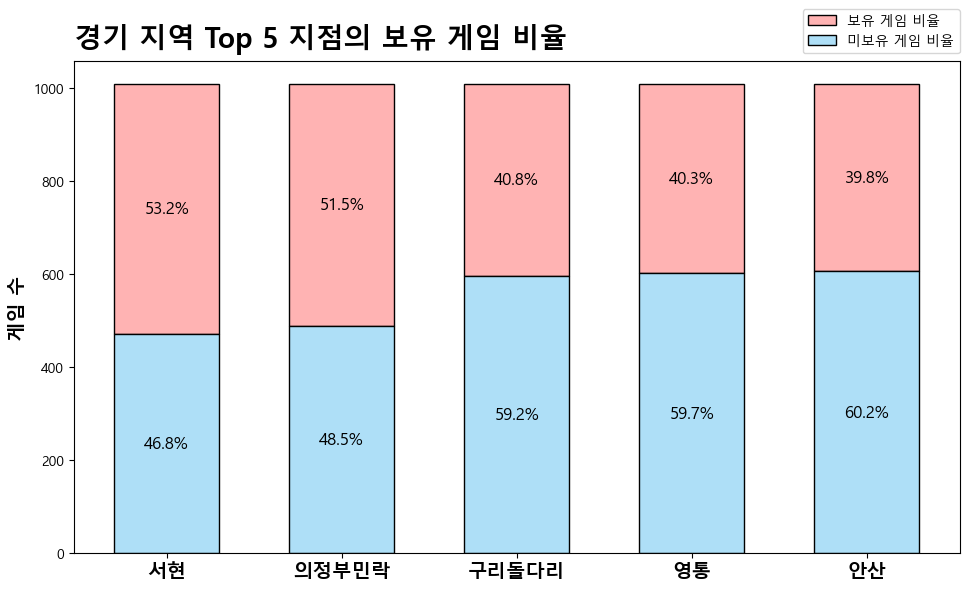

In [11]:
# Top 5 보유 지점
top5 = region_df.sort_values(by='보유 게임 수', ascending=False).head(5).reset_index(drop=True)

# 5개 미만 시 빈 막대 추가
while len(top5) < 5:
    top5 = pd.concat([top5, pd.DataFrame([{
        '지점명': '',
        '보유 게임 수': 0,
        '미보유 게임 수': 0
    }])], ignore_index=True)

# 누적 막대차트 생성
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(top5))
bar_width = 0.6

# 비율 계산
top5["총 게임 수"] = top5["보유 게임 수"] + top5["미보유 게임 수"]
top5["보유 비율"] = (top5["보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)
top5["미보유 비율"] = (top5["미보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)

# 색상 설정
colors = {
    '보유': '#FFB3B3',     # 연한 붉은색
    '미보유': '#AEDFF7'    # 연한 하늘색
}

# 막대 그리기 + 테두리
bar1 = ax.bar(x, top5['보유 게임 수'], width=bar_width, color=colors['보유'],
              bottom=top5['미보유 게임 수'], edgecolor='black', label='보유 게임 비율')
bar2 = ax.bar(x, top5['미보유 게임 수'], width=bar_width, color=colors['미보유'],
              edgecolor='black', label='미보유 게임 비율')

# 비율 텍스트 표시
for i in range(len(top5)):
    if top5["지점명"][i] != "":
        ax.text(x[i], top5['미보유 게임 수'][i] / 2,
                f"{top5['미보유 비율'][i]:.1f}%", ha='center', va='center', fontsize=12, color='black')
        ax.text(x[i], top5['미보유 게임 수'][i] + top5['보유 게임 수'][i] / 2,
                f"{top5['보유 비율'][i]:.1f}%", ha='center', va='center', fontsize=12, color='black')

# X축 설정
ax.set_xticks(x)
ax.set_xticklabels(top5['지점명'], fontsize=14, fontweight="bold")

# 타이틀 (좌측 정렬)
ax.set_title(f"{selected_region} 지역 Top 5 지점의 보유 게임 비율",
             fontsize=20, fontweight="bold", loc='left', pad=10)

# y축 레이블
ax.set_ylabel("게임 수", fontsize=14, fontweight="bold")

# 범례 (타이틀 오른쪽 우상단 위치)
ax.legend(loc='center left', bbox_to_anchor=(0.815, 1.06), fontsize=10)

fig.tight_layout()
plt.show()

#### **묶은 막대 차트**

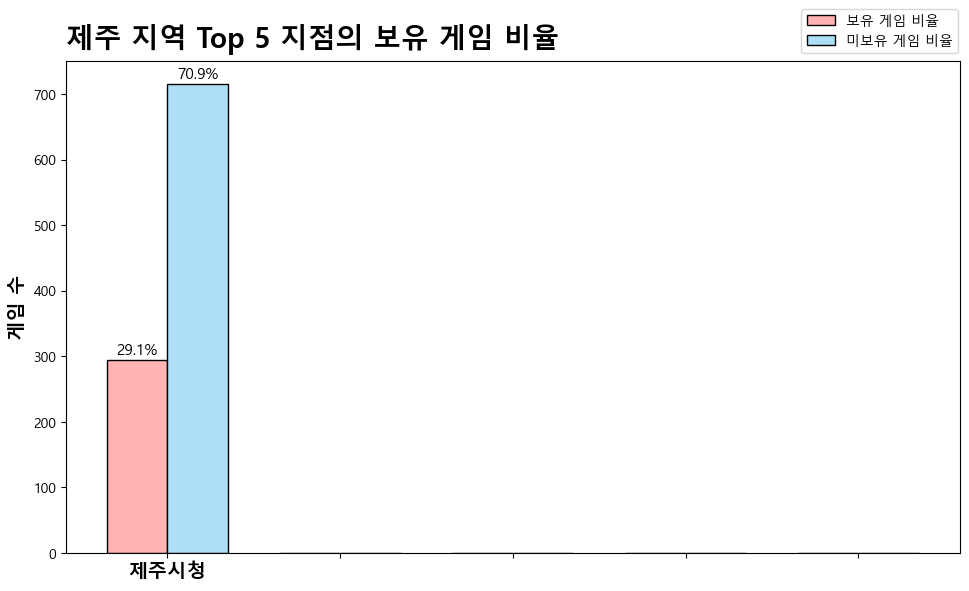

In [106]:
# Top 5 보유 지점
top5 = region_df.sort_values(by='보유 게임 수', ascending=False).head(5).reset_index(drop=True)

# 5개 미만 시 빈 막대 추가
while len(top5) < 5:
    top5 = pd.concat([top5, pd.DataFrame([{
        '지점명': '',
        '보유 게임 수': 0,
        '미보유 게임 수': 0
    }])], ignore_index=True)

# 차트 생성
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(top5))
bar_width = 0.35  # 각 막대 너비 줄이기

# 비율 계산
top5["총 게임 수"] = top5["보유 게임 수"] + top5["미보유 게임 수"]
top5["보유 비율"] = (top5["보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)
top5["미보유 비율"] = (top5["미보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)

# 색상 설정
colors = {
    '보유': '#FFB3B3',
    '미보유': '#AEDFF7'
}

# 묶은 막대 그리기
bar1 = ax.bar(x - bar_width/2, top5['보유 게임 수'], width=bar_width,
              color=colors['보유'], edgecolor='black', label='보유 게임 비율')
bar2 = ax.bar(x + bar_width/2, top5['미보유 게임 수'], width=bar_width,
              color=colors['미보유'], edgecolor='black', label='미보유 게임 비율')

# 비율 텍스트 표시 (각 막대 위에 표시)
for i in range(len(top5)):
    if top5["지점명"][i] != "":
        ax.text(x[i] - bar_width/2, top5['보유 게임 수'][i] + 3,
                f"{top5['보유 비율'][i]:.1f}%", ha='center', va='bottom', fontsize=11)
        ax.text(x[i] + bar_width/2, top5['미보유 게임 수'][i] + 3,
                f"{top5['미보유 비율'][i]:.1f}%", ha='center', va='bottom', fontsize=11)

# X축 설정
ax.set_xticks(x)
ax.set_xticklabels(top5['지점명'], fontsize=14, fontweight="bold")

# 타이틀 (좌측 정렬)
ax.set_title(f"{selected_region} 지역 Top 5 지점의 보유 게임 비율",
             fontsize=20, fontweight="bold", loc='left', pad=10)

# y축 레이블
ax.set_ylabel("게임 수", fontsize=14, fontweight="bold")

# 범례 (타이틀 오른쪽 우상단)
ax.legend(loc='center left', bbox_to_anchor=(0.815, 1.06), fontsize=10)

fig.tight_layout()
plt.show()

# 차트 저장
file_name = f"{region_eng}_bar_chart.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')

---
### **2-2. 워드클라우드 - 선택 지역 고유 보드게임**

#### **지역 고유 보드게임 워드클라우드**

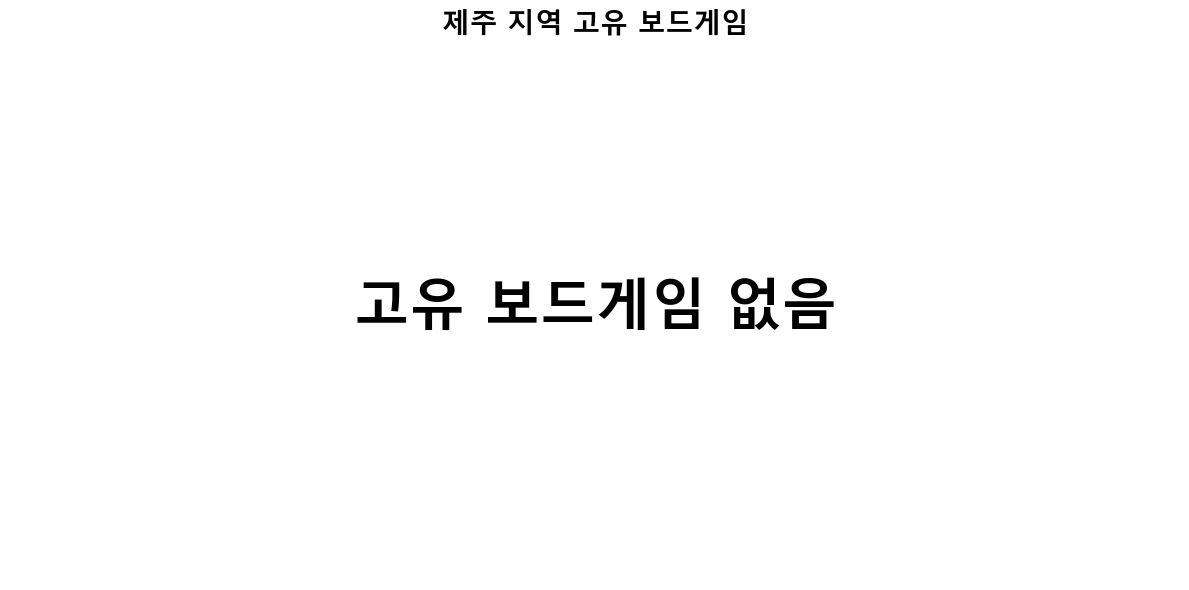

In [144]:
# 선택 지역과 타 지역으로 분리
region_df = df[df["지역"] == selected_region].copy()
other_df = df[df["지역"] != selected_region].copy()

# 각 지역의 보유 게임 set 추출
def extract_games(df):
    return set(
        game.strip()
        for games in df["보유 게임 목록"].dropna()
        for game in games.split(',')
        if game.strip() != ''
    )

region_games = extract_games(region_df)
other_games = extract_games(other_df)

# 고유 게임 = 선택 지역에서만 등장하는 게임
unique_games = region_games - other_games

# 고유 게임이 존재하면: 해당 게임이 지역 내 몇 개 지점에서 보유되고 있는지 count
if unique_games:
    game_counter = Counter()
    for games in region_df["보유 게임 목록"].dropna():
        game_list = [g.strip() for g in games.split(',')]
        for game in game_list:
            if game in unique_games:
                game_counter[game] += 1

    word_freq = dict(game_counter)

    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white',
        random_state=42
    ).generate_from_frequencies(word_freq)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"{selected_region} 지역 고유 보드게임", fontsize=20, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # 이미지 저장
    wordcloud.to_file(f"{region_eng}_word_cloud.png")

else:
    # 고유 보드게임이 없을 경우 → 텍스트 수동 표시
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.text(0.5, 0.5, "고유 보드게임 없음", fontsize=40, fontweight="bold",
            ha='center', va='center', fontname='Malgun Gothic')
    ax.axis("off")
    ax.set_title(f"{selected_region} 지역 고유 보드게임", fontsize=20, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # 이미지 저장 (워드클라우드가 아닌 fig 자체 저장)
    file_name = f"{region_eng}_word_cloud.png"
    fig.savefig(file_name, dpi=300, bbox_inches='tight')

---

### **2-3. 히트맵 - 선택 지역 보유/미보유 게임 수**

#### **히트맵**

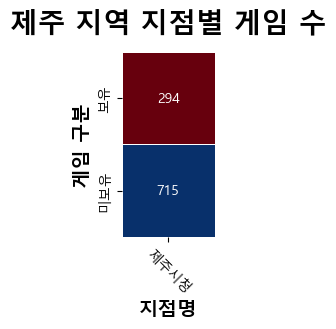

In [174]:
# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "제주"  # 예시 지역 (웹에선 동적으로 바뀔 것)

region_eng = region_name_map.get(selected_region, "unknown")  # fallback 설정

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]




# pivot 및 정렬
pivot = region_df[["지점명", "보유 게임 수", "미보유 게임 수"]].set_index("지점명").T
pivot.index = ["보유", "미보유"]
pivot = pivot.loc[:, pivot.loc["보유"].sort_values(ascending=False).index]

# 값 범위
vmin_b = pivot.loc["보유"].min() * 0.9  # 또는 -10, 0 등으로 고정
vmax_b = pivot.loc["보유"].max()

# 예: 미보유 기준
vmin_m = pivot.loc["미보유"].min() * 0.9
vmax_m = pivot.loc["미보유"].max()

# 마스크 생성 함수
def get_row_mask(df, target_row_label):
    return pd.DataFrame(
        [[row != target_row_label for _ in df.columns] for row in df.index],
        index=df.index,
        columns=df.columns
    )

mask_boyu = get_row_mask(pivot, "보유")
mask_miboyu = get_row_mask(pivot, "미보유")

# 셀당 크기를 기준으로 정사각형 유지
cell_size = 1.2
fig_width = len(pivot.columns) * cell_size
fig_height = len(pivot.index) * cell_size

fig3, ax3 = plt.subplots(figsize=(fig_width, fig_height))

# 1. 보유: 파랑 계열
sns.heatmap(pivot, cmap="Reds", linewidths=0.5, annot=True, fmt=".0f",
            ax=ax3, cbar=False, mask=mask_boyu, vmin=vmin_b, vmax=vmax_b)

# 2. 미보유: 빨강 계열
sns.heatmap(pivot, cmap="Blues", linewidths=0.5, annot=True, fmt=".0f",
            ax=ax3, cbar=False, mask=mask_miboyu, vmin=vmin_m, vmax=vmax_m)

# 라벨
ax3.set_title(f"{selected_region} 지역 지점별 게임 수", fontsize=20, fontweight="bold", pad=15)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=-45, fontsize=10)
ax3.set_xlabel("지점명", fontsize=14, fontweight="bold")
ax3.set_ylabel("게임 구분", fontsize=14, fontweight="bold")

# 차트 저장
file_name = f"{region_eng}_heatmap.png"
fig3.savefig(file_name, dpi=300, bbox_inches='tight')

plt.show()

---

### **2-4. 파이 차트 - 이달의 게임 보유/미보유 지점 수**

#### **이달의 게임 보유/미보유 지점 파이차트**

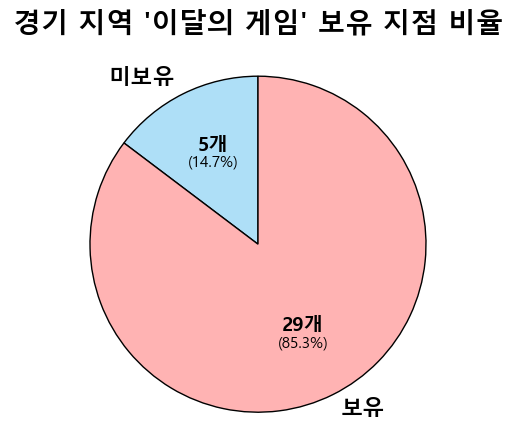

In [24]:
# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "경기"  # 예시 지역 (웹에선 동적으로 바뀔 것)

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]

# 색상 및 라벨
colors_full = ["#AEDFF7", "#FFB3B3"]
labels_full = ["미보유", "보유"]

# 데이터 준비
total = len(region_df)
true_count = region_df["이달의게임_보유_여부"].sum()
false_count = total - true_count
sizes_full = [false_count, true_count]

# 0이 아닌 항목만 추출
sizes = []
colors = []
labels = []
for i, size in enumerate(sizes_full):
    if size > 0:
        sizes.append(size)
        colors.append(colors_full[i])
        labels.append(labels_full[i])

# 항상 검은 테두리 설정
wedgeprops = {'edgecolor': 'black', 'linewidth': 1}

# 파이차트 그리기
fig, ax = plt.subplots()
wedges, texts = ax.pie(
    sizes,
    labels=labels if len(sizes) > 1 else None,  # 라벨은 2개 이상일 때만
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops
)

if len(sizes) == 1:
    # 단일 조각일 때 중앙 텍스트 표시
    count = sizes[0]
    pct = 100.0
    label = labels[0]

    ax.text(0, 0.15, f"{label}", ha='center', va='center', fontsize=16, weight='bold')
    ax.text(0, 0, f"{count}개", ha='center', va='center', fontsize=14, weight='bold')
    ax.text(0, -0.15, f"({pct:.1f}%)", ha='center', va='center', fontsize=12)

else:
    # 여러 조각일 때 텍스트 wedge 옆에 표시
    for i, wedge in enumerate(wedges):
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))
        x_text = 0.6 * x
        y_text = 0.6 * y

        count = sizes[i]
        pct = count / sum(sizes) * 100

        ax.text(x_text, y_text + 0.05, f"{count}개", ha='center', va='center', fontsize=14, weight='bold')
        ax.text(x_text, y_text - 0.05, f"({pct:.1f}%)", ha='center', va='center', fontsize=11)

    for text in texts:
        text.set_fontsize(16)
        text.set_weight("bold")

ax.axis("equal")
plt.title(f"{selected_region} 지역 '이달의 게임' 보유 지점 비율", fontsize=20, fontweight="bold", pad=20)
plt.show()